обрали тестувальний сет як 20% від кількосьі вибірки

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

from scipy.stats import jarque_bera
from sklearn.metrics import r2_score
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('fivethirtyeight')

lags=60
precent_train_set = 0.8
rolling_value = 10


In [2]:
file1 = open('ATS_Lab_04_new/data/RSAFSNA.txt')
file_text_1 = file1.read()
y = np.array([float(x) for x in file_text_1.split()])

In [3]:
date = np.array('1992-02', dtype=np.datetime64)
date = date + np.arange(len(y))

In [4]:
df_y = pd.DataFrame({'Date': date, 'Value':y})
df_y = df_y.set_index('Date')

#### <a href='https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-one/'> Source <a/>

## Visualizate the data

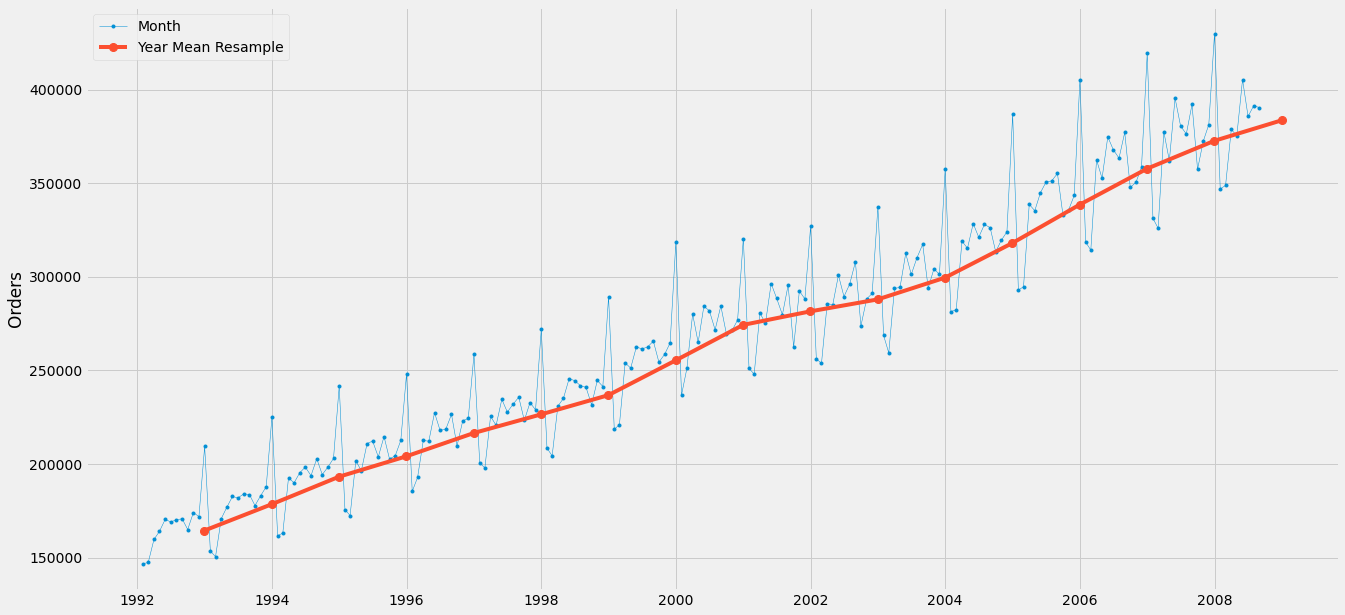

In [5]:
y = df_y
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Month')
ax.plot(y.resample('Y').mean(),marker='o', markersize=8, linestyle='-', label='Year Mean Resample')
ax.set_ylabel('Orders')
ax.legend();

## Decomposing the Data

In [6]:
import statsmodels.api as sm

def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

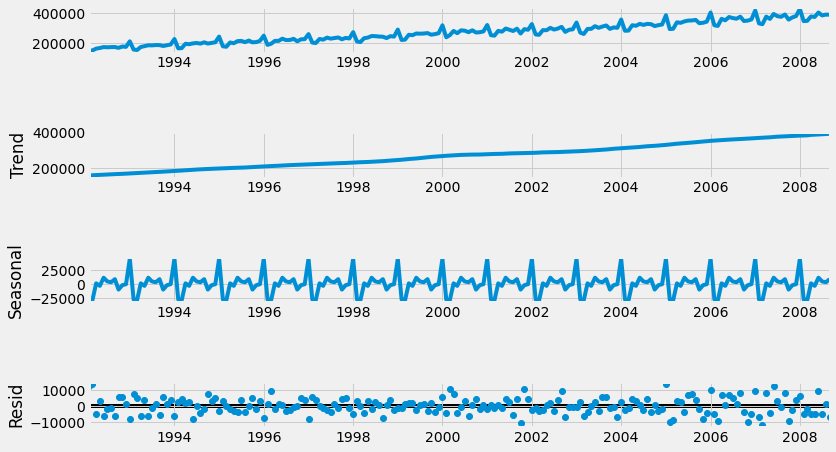

In [7]:
seasonal_decompose(df_y)

## Checking Stationarity

In [8]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=rolling_value).mean() 
    rolstd = pd.Series(timeseries).rolling(window=rolling_value).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

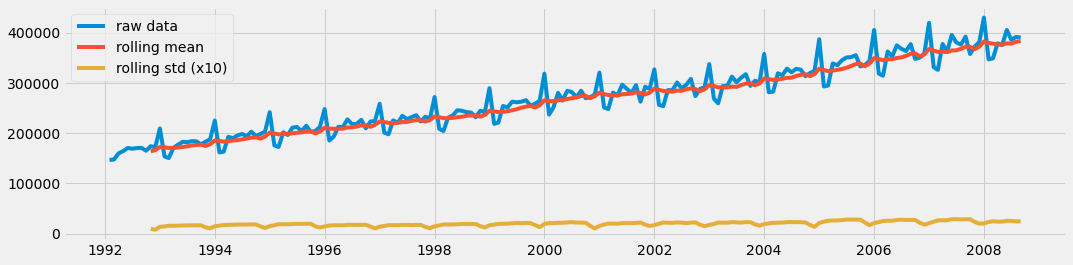

In [9]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y.Value,'raw data')

## Augmented Dickey-Fuller Test

In [10]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [11]:
ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = -0.026
P-value = 0.956
Critical values :
	1%: -3.4662005731940853 - The data is not stationary with 99% confidence
	5%: -2.8772932777920364 - The data is not stationary with 95% confidence
	10%: -2.575167750182615 - The data is not stationary with 90% confidence


## Detrending

 > Is the de-trended data stationary ?
Test statistic = -2.248
P-value = 0.189
Critical values :
	1%: -3.4680615871598537 - The data is not stationary with 99% confidence
	5%: -2.8781061899535128 - The data is not stationary with 95% confidence
	10%: -2.5756015922004134 - The data is not stationary with 90% confidence


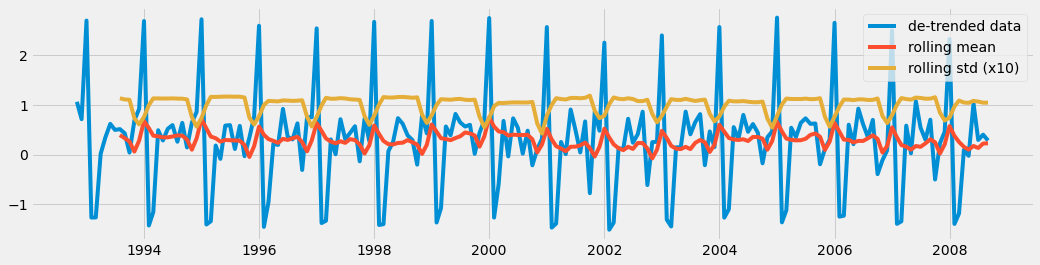

In [12]:
# Detrending
y_detrend =  (y - y.rolling(window=rolling_value).mean())/y.rolling(window=rolling_value).std()

test_stationarity(y_detrend.Value,'de-trended data')
ADF_test(y_detrend,'de-trended data')

## Differencing

 > Is the 1 lag differenced data stationary ?
Test statistic = -3.171
P-value = 0.022
Critical values :
	1%: -3.4662005731940853 - The data is not stationary with 99% confidence
	5%: -2.8772932777920364 - The data is  stationary with 95% confidence
	10%: -2.575167750182615 - The data is  stationary with 90% confidence


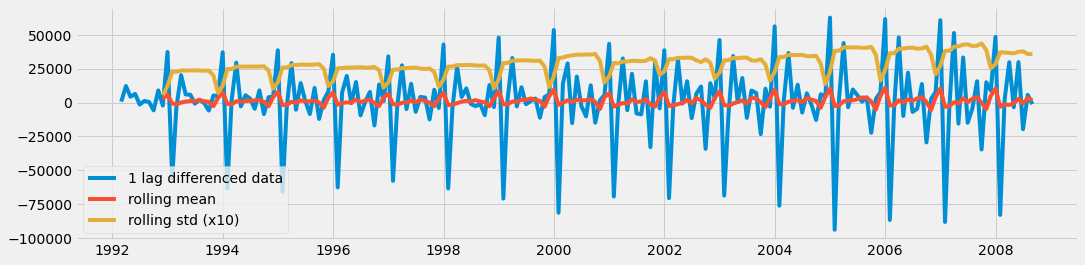

In [13]:
# Differencing
diff_model = 1
y_10lag =  y - y.shift(diff_model)

test_stationarity(y_10lag.Value,f'{diff_model} lag differenced data')
ADF_test(y_10lag,f'{diff_model} lag differenced data')

## Combining Detrending and Differencing


 > Is the 1 lag differenced de-trended data stationary ?
Test statistic = -5.426
P-value = 0.000
Critical values :
	1%: -3.4680615871598537 - The data is  stationary with 99% confidence
	5%: -2.8781061899535128 - The data is  stationary with 95% confidence
	10%: -2.5756015922004134 - The data is  stationary with 90% confidence


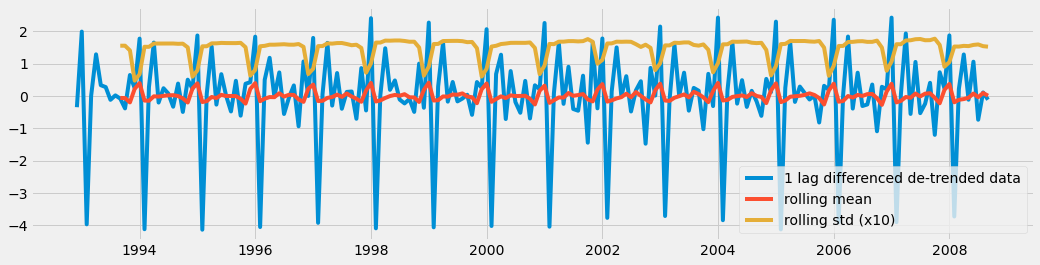

In [14]:
y_10lag_detrend =  y_detrend - y_detrend.shift(diff_model)

test_stationarity(y_10lag_detrend.Value,f'{diff_model} lag differenced de-trended data')
ADF_test(y_10lag_detrend.Value,f'{diff_model} lag differenced de-trended data')

## Create Training & Testing Datasets


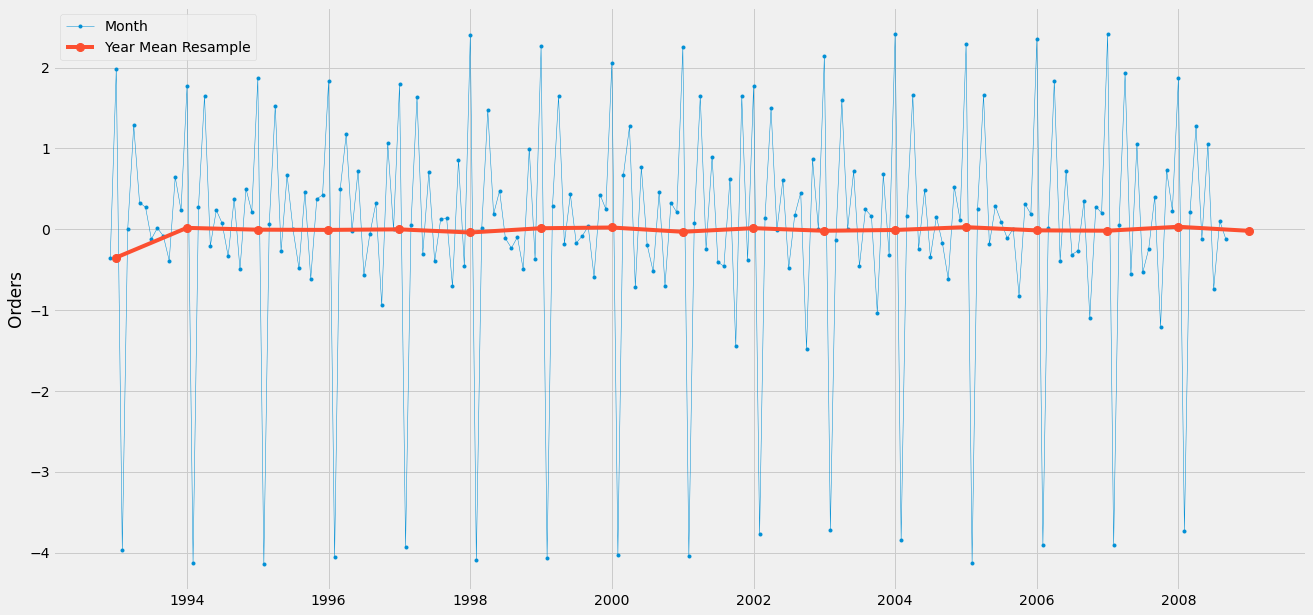

In [15]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(y_10lag_detrend,marker='.', linestyle='-', linewidth=0.5, label='Month')
ax.plot(y_10lag_detrend.resample('Y').mean(),marker='o', markersize=8, linestyle='-', label='Year Mean Resample')
ax.set_ylabel('Orders')
ax.legend();

In [16]:
def calculate_metrics_sample(y):
   
    print('yes')
    sample = pd.Series(y)
    
    y_dict = {}

    y_dict['series'] = 'Y'
    y_dict['observations'] = sample.size
    y_dict['mode'] = sample.mode()[0]
    y_dict['mean'] = sample.mean()
    y_dict['median'] = sample.median()
    y_dict['variation'] = sample.var()
    y_dict['skewness'] = sample.skew()
    y_dict['kurtosis'] = sample.kurt()
    y_dict['jarque-bera'] = jarque_bera(sample).statistic
    y_dict['probability'] = jarque_bera(sample).pvalue
    
    return pd.DataFrame(np.array([[metr] for metr in y_dict.values()]).T, 
                        columns=['series', 'observations', 'mode','mean','median',
                                 'variation','skewness','kurtosis','jarque-bera','probability'])#,'params_ar','params_intercept'])

#### <a href='https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-two/'> Source 2</a>

In [17]:
def show_plots(y):
    sample = pd.Series(y)
    plt.figure(figsize=(20,6))
    plt.title('Sample')
    plt.xlabel('k')
    plt.ylabel('y')
    plt.plot(sample, marker='o')
    plt.grid(True)
    plt.show();
    
    plot_pacf(sample, lags=lags);
    plot_acf(sample, lags=lags);

# Metrics

In [18]:
columns =['name', 'r2', 'RMSE','MAE','sum_squared_resid','AIC','durbin_watson','theil_index']

models_metrics_static = pd.DataFrame(columns=columns)
models_metrics_static_test = pd.DataFrame(columns=columns)

calculate_metrics_sample(y.Value)

yes


,series,observations,mode,mean,median,variation,skewness,kurtosis,jarque-bera,probability
0,Y,200,146737.0,268831.08,264861.0,4655234022.07397,0.22007611501127924,-0.8901924464689346,8.309463126688069,0.015690002336133824


In [19]:
y_10lag_detrend

,Value
Date,
1992-02-01,nan
1992-03-01,nan
1992-04-01,nan
1992-05-01,nan
1992-06-01,nan
...,...
2008-05-01,-0.11848186
2008-06-01,1.05680777
2008-07-01,-0.73737247


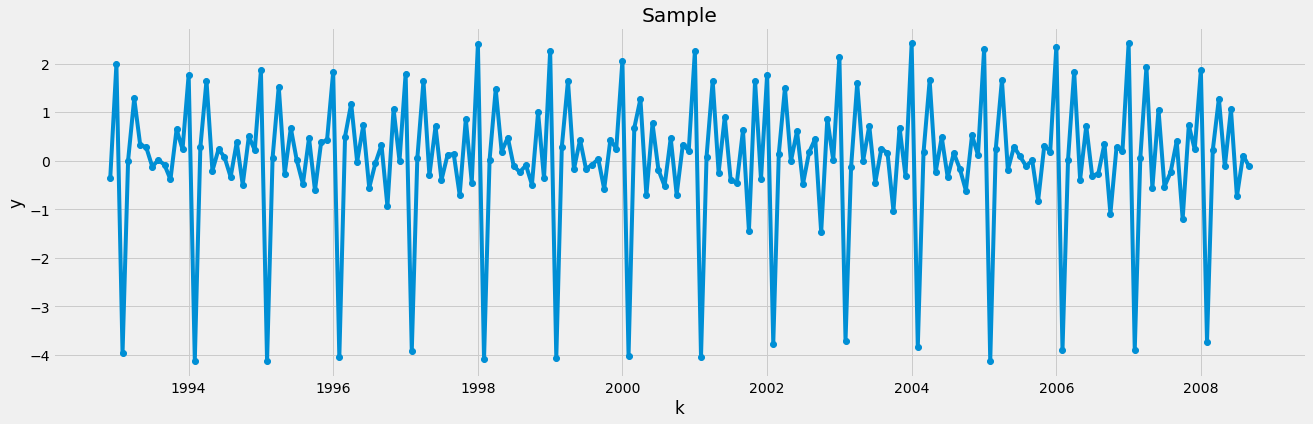

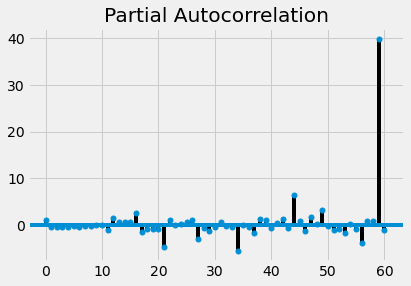

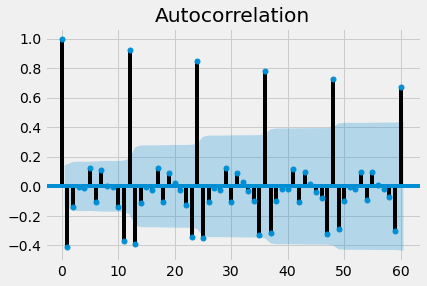

In [20]:
show_plots(y_10lag_detrend.Value.dropna())
# plot_pacf(y_10lag, lags=lags);
# plot_acf(y_10lag, lags=lags);

## Fitting ARIMA Model

In [21]:
def AR(p, df, test=True):
    df_temp = df
    
    #Generating the lagged p terms
    for i in range(1,p+1):
        df_temp[f'Shifted_values_{i}'] = df_temp['Value'].shift(i)
    
    train_size = (int)(precent_train_set * df_temp.shape[0])

    #Breaking data set into test and training
    df_train = pd.DataFrame(df_temp[0:train_size])
    df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

    df_train_2 = df_train.dropna()

    #X contains the lagged values ,hence we skip the first column
    X_train = df_train_2.iloc[:,1:].values.reshape(-1,p)

    #Y contains the value,it is the first column
    y_train = df_train_2.iloc[:,0].values.reshape(-1,1)

    lr = LinearRegression()
    lr.fit(X_train,y_train)

    theta  = lr.coef_.T
    intercept = lr.intercept_
    df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_

    X_test = df_test.iloc[:,1:].values.reshape(-1,p)
    df_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_

    RMSE = np.sqrt(mean_squared_error(df_test['Value'], df_test['Predicted_Values']))

    return df_train_2,df_test,theta.reshape((len(theta),)),intercept[0],RMSE

In [22]:
def claculate_metrics_model(y, y_pred, name, count_parameters):
    return pd.DataFrame({'name':[name],
                              'r2':[r2_score(df_test['Value'], df_test['Predicted_Values'])],
                              'RMSE':[np.sqrt(mean_squared_error(df_test['Value'], df_test['Predicted_Values']))],
                              'MAE':[mean_absolute_error(y, y_pred)],
                              'sum_squared_resid':[np.sum((y - y_pred)**2)],
                              'AIC':[len(y) * np.log(np.sum((y - y_pred)**2) / len(y)) + 2*count_parameters],
                              'durbin_watson': [durbin_watson(y - y_pred)],
                        'theil_index':[np.sqrt((1/len(y_pred))*np.sum((y-y_pred)**2))
                                      / (np.sqrt((1/len(y))*np.sum(y**2)) + np.sqrt((1/len(y_pred))*np.sum(y_pred**2)))],
                        }
        )

## Choosing parameters for AR model

In [23]:
models_metrics_ar = pd.DataFrame(columns=columns)

best_RMSE = 1e15
best_p = -1

for i in range(1, 50):
    df_train, df_test, theta, intercept, RMSE = AR(i, pd.DataFrame(y_10lag_detrend.Value))
    metric = claculate_metrics_model(df_test.Value, df_test.Predicted_Values, f'AR({i})', i)
    models_metrics_ar = models_metrics_ar.append(metric)
        
    if RMSE < best_RMSE:
        best_RMSE = RMSE
        best_p = i
        
print(f'best_p:\t{best_p}')

best_p:	35


In [24]:
models_metrics_ar

,name,r2,RMSE,MAE,sum_squared_resid,AIC,durbin_watson,theil_index
0,AR(1),0.16827692,1.26480213,0.89439655,63.98897684,20.79325510,2.33383919,0.64506226
0,AR(2),0.30098994,1.15951114,0.79777367,53.77864316,15.83987868,2.25858248,0.54497191
0,AR(3),0.36272893,1.10712157,0.82398760,49.02872686,14.14107738,2.30649245,0.50377285
0,AR(4),0.46330873,1.01600414,0.78293682,41.29057671,9.27019412,2.20693809,0.44037333
0,AR(5),0.49187482,0.98859536,0.80128444,39.09283179,9.08238663,2.21020439,0.42492330
0,AR(6),0.56219584,0.91764173,0.71270460,33.68265388,5.12414116,2.22687421,0.38480443
0,AR(7),0.59231954,0.88550937,0.66435083,31.36507359,4.27262055,2.19937807,0.37045310
0,AR(8),0.59710664,0.88029507,0.65492999,30.99677611,5.80014994,2.16957563,0.36837248
0,AR(9),0.61557503,0.85988229,0.66621569,29.57590208,5.92321827,2.18540894,0.35757916
0,AR(10),0.61873547,0.85634036,0.66701785,29.33275263,7.59301099,2.12391878,0.35587591


In [25]:
best_p_arima = 12
df_train_lag,df_test_lag,theta_ar_lag,intercept_ar_lag,RMSE = AR(best_p_arima,pd.DataFrame(y_10lag_detrend.Value))

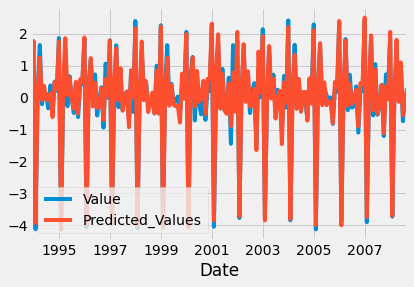

In [26]:
df_c_arima = pd.concat([df_train_lag,df_test_lag])
df_c_arima[['Value','Predicted_Values']].plot()

In [27]:
def MA(q, res):
    
    for i in range(1,q+1):
         res[f'Shifted_values_{i}'] = res['Residuals'].shift(i)

    train_size = (int)(precent_train_set * res.shape[0])

    res_train = pd.DataFrame(res[0:train_size])
    res_test = pd.DataFrame(res[train_size:res.shape[0]])

    res_train_2 = res_train.dropna()
    X_train = res_train_2.iloc[:,1:].values.reshape(-1,q)
    y_train = res_train_2.iloc[:,0].values.reshape(-1,1)

    lr = LinearRegression()
    lr.fit(X_train,y_train)

    theta  = lr.coef_.T
    intercept = lr.intercept_
    res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_

    X_test = res_test.iloc[:,1:].values.reshape(-1,q)
    res_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
#     res_test[['Residuals','Predicted_Values']].plot()

    RMSE = np.sqrt(mean_squared_error(res_test['Residuals'], res_test['Predicted_Values']))

#     print("The RMSE is :", RMSE,", Value of q : ",q)
    return [res_train_2,res_test,theta.reshape((len(theta),)),intercept[0],RMSE]

In [28]:
res = pd.DataFrame()
res['Residuals'] = df_c_arima.Value - df_c_arima.Predicted_Values

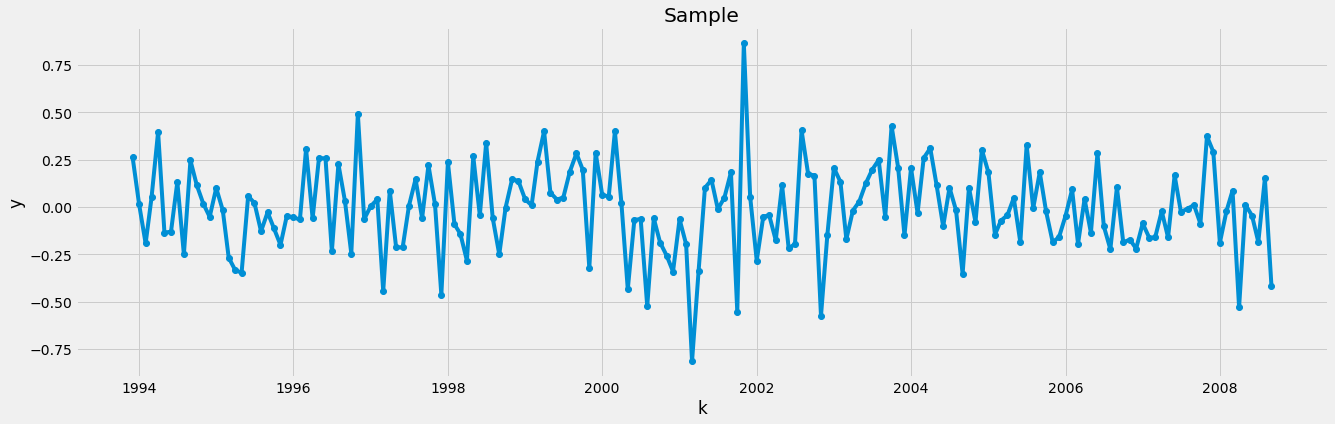

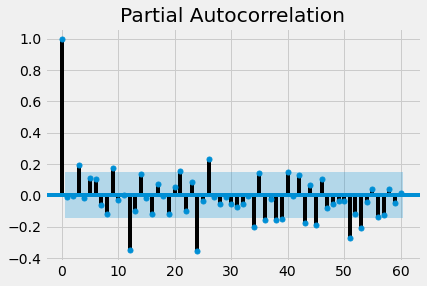

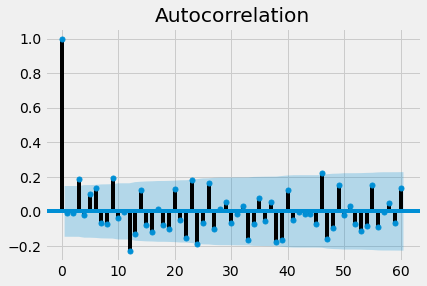

In [29]:
show_plots(res.Residuals.dropna())

## Choosing parameters for MA model

In [30]:
models_metrics_ma = pd.DataFrame(columns=columns)


best_RMSE=100000000000
best_q = -1

for i in range(1,50):
    
    res_train, res_test,theta,intercept,RMSE = MA(i,pd.DataFrame(res.Residuals))
    metric = claculate_metrics_model(res_test.Residuals, res_test.Predicted_Values, f'MA({i})', i)
    models_metrics_ma = models_metrics_ma.append(metric)
    
    
    if(RMSE<best_RMSE):
        best_RMSE = RMSE
        best_q = i

In [31]:
print(f'best_q:\t {best_q}')

best_q:	 24


In [32]:
models_metrics_ma

,name,r2,RMSE,MAE,sum_squared_resid,AIC,durbin_watson,theil_index
0,MA(1),0.97044889,0.23840761,0.14943080,1.30229403,-117.49809721,2.00179074,0.99877954
0,MA(2),0.97044889,0.23840761,0.14985693,1.30618852,-115.39060041,1.99021746,0.98434487
0,MA(3),0.97044889,0.23840761,0.14540226,1.22993592,-115.55604729,1.94521994,0.82629865
0,MA(4),0.97044889,0.23840761,0.14539851,1.22928979,-113.57496443,1.94488635,0.82594531
0,MA(5),0.97044889,0.23840761,0.14076704,1.18647189,-112.85125411,1.93900173,0.78529015
0,MA(6),0.97044889,0.23840761,0.14626806,1.24212142,-109.20113513,1.89221752,0.79210242
0,MA(7),0.97044889,0.23840761,0.14798615,1.25305081,-106.88575756,1.93741828,0.78909377
0,MA(8),0.97044889,0.23840761,0.14500802,1.23586882,-105.38280979,1.87666882,0.76741439
0,MA(9),0.97044889,0.23840761,0.13780447,1.21109790,-104.11169884,1.76280621,0.75462715
0,MA(10),0.97044889,0.23840761,0.13848299,1.22122622,-101.81188558,1.77961423,0.75871676


In [33]:
best_q_arima=24
res_train_lag,res_test_lag,theta_ma_lag,intercept_ma_lag,RMSE = MA(best_q_arima,pd.DataFrame(res.Residuals))
# print(f'theta: {theta}')
# print(f'intercept: {intercept}')

In [34]:
res_c_lag = pd.concat([res_train_lag,res_test_lag])
df_c_arima.Predicted_Values += res_c_lag.Predicted_Values

## Plot before come back to real value

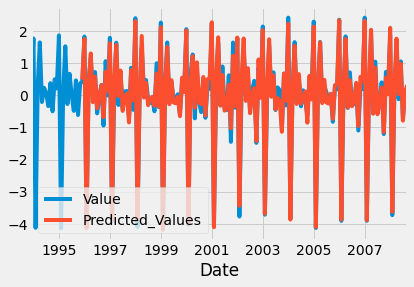

In [35]:
df_c_arima[['Value','Predicted_Values']].plot()

In [36]:
df_c_arima.Predicted_Values += y_detrend.shift(diff_model).Value
df_c_arima.Predicted_Values *= y.rolling(window=rolling_value).std().Value
df_c_arima.Predicted_Values += y.rolling(window=rolling_value).mean().Value


df_c_arima.Value += y_detrend.shift(diff_model).Value
df_c_arima.Value *= y.rolling(window=rolling_value).std().Value
df_c_arima.Value += y.rolling(window=rolling_value).mean().Value

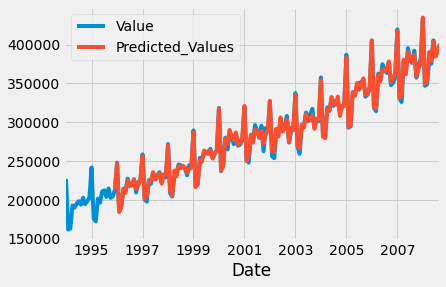

In [37]:
df_c_arima.iloc[:,:][['Value','Predicted_Values']].plot()

In [38]:
def show_prediction(y, y_pred, name='', pred_title='pred'):
    plt.figure(figsize= (15,6.5))
    plt.title(name)
    plt.plot(y, label='y', marker='o')
    plt.plot(y_pred, label=pred_title, marker='o')
    plt.legend()
    plt.show()

## Plot after come back

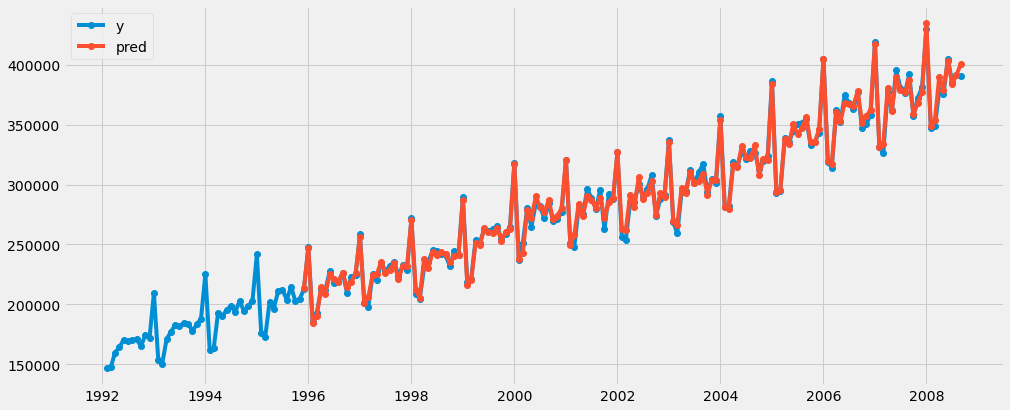

In [39]:
show_prediction(y, df_c_arima.Predicted_Values)

## metrics for ARIMA model

In [40]:
predictions = df_c_arima.Predicted_Values.dropna()[df_test_lag.index]
values = y.Value[df_test_lag.index]
name = f'ARIMA_test{best_p_arima,diff_model,best_q_arima}'
parametrs = best_p_arima+best_q_arima + diff_model
metrics = claculate_metrics_model(values, predictions, name=name, count_parameters=parametrs)
models_metrics_static_test = models_metrics_static_test.append(metrics)

In [41]:
predictions = df_c_arima.Predicted_Values.dropna()
values = y.Value[df_c_arima.Predicted_Values.dropna().index]
name = f'ARIMA{best_p_arima,diff_model,best_q_arima}'
parametrs = best_p_arima+best_q_arima + diff_model
metrics = claculate_metrics_model(values, predictions, name=name, count_parameters=parametrs)
models_metrics_static = models_metrics_static.append(metrics)

# ====================================================

# Fiting ARMA model on detrended values

usnig only detrending values

In [42]:
calculate_metrics_sample(y_detrend.Value.dropna())

yes


,series,observations,mode,mean,median,variation,skewness,kurtosis,jarque-bera,probability
0,Y,191,-1.5139975973039137,0.29430675771472503,0.3547550682481003,0.9700530694941747,0.36764637130392375,0.8640800289136732,9.461555070875926,0.008819610813081469


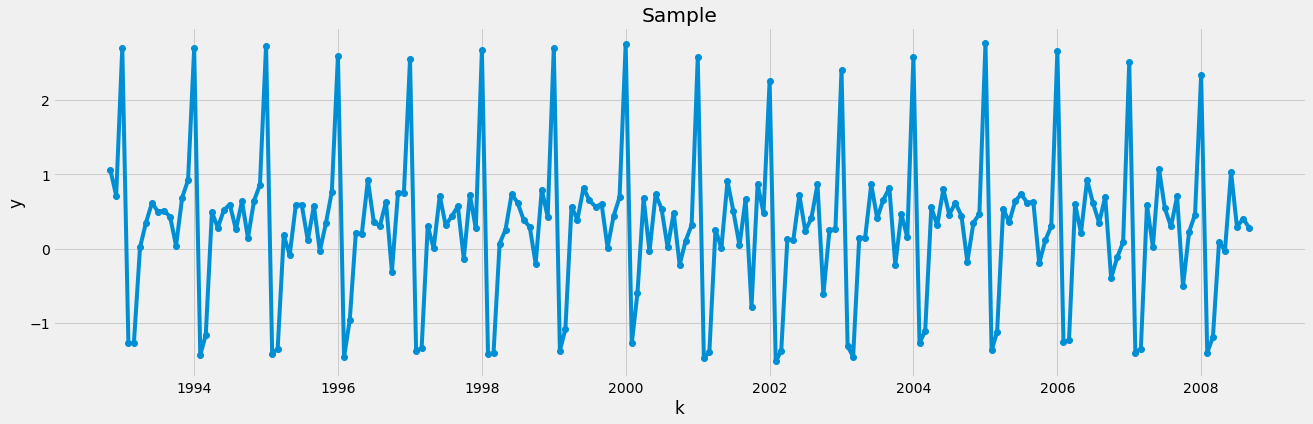

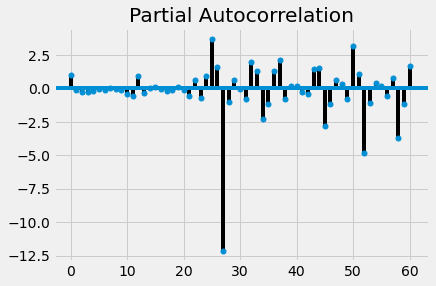

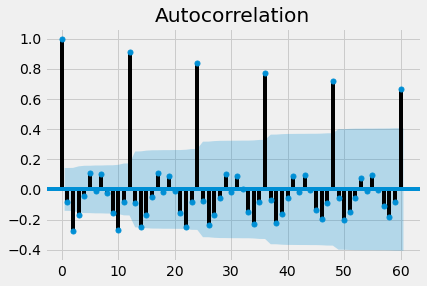

In [43]:
show_plots(y_detrend.Value.dropna())

## Choosing AR model

In [44]:
models_metrics_ar = pd.DataFrame(columns=columns)

best_RMSE = 1e15
best_p = -1

for i in range(1, 50):
    df_train, df_test, theta, intercept, RMSE = AR(i, pd.DataFrame(y_detrend.Value))
    metric = claculate_metrics_model(df_test.Value, df_test.Predicted_Values, f'AR({i})', i)
    models_metrics_ar = models_metrics_ar.append(metric)
        
    if RMSE < best_RMSE:
        best_RMSE = RMSE
        best_p = i
        
print(f'best_p:\t{best_p}')

best_p:	36


In [45]:
models_metrics_ar

,name,r2,RMSE,MAE,sum_squared_resid,AIC,durbin_watson,theil_index
0,AR(1),0.01118040,0.92418014,0.64648994,34.16435754,-4.30786123,2.11813363,0.72532488
0,AR(2),0.11454712,0.87454232,0.66880891,30.59297052,-6.72436773,2.21391403,0.64056798
0,AR(3),0.16775086,0.84786123,0.64296820,28.75474657,-7.20306409,2.22198075,0.59497841
0,AR(4),0.21443684,0.82373715,0.58968570,27.14171595,-7.51230303,2.15795602,0.55847415
0,AR(5),0.21796702,0.82188421,0.57791500,27.01974586,-5.69246109,2.14980785,0.55796864
0,AR(6),0.24289557,0.80867868,0.55291079,26.15844846,-4.98828955,2.10456502,0.54106873
0,AR(7),0.24526770,0.80741082,0.55901114,26.07648955,-3.11381317,2.12035113,0.53855340
0,AR(8),0.24287517,0.80868958,0.56636545,26.15915322,-0.98721189,2.11768212,0.53591847
0,AR(9),0.22443020,0.81848089,0.58170104,26.79643880,1.97558176,2.24593683,0.53316252
0,AR(10),0.39373585,0.72365079,0.55975965,20.94681885,-5.87570656,2.50568277,0.44093224


In [46]:
best_p_ar = 12
df_train_ar,df_test_ar,theta_ar,intercept_ar,RMSE = AR(best_p_ar,pd.DataFrame(y_detrend.Value))

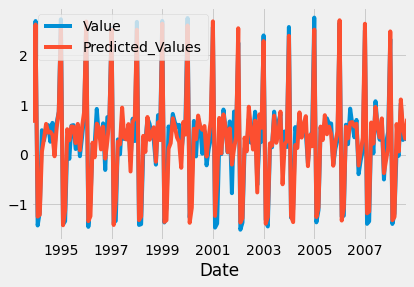

In [47]:
df_c_ar = pd.concat([df_train_ar,df_test_ar])
df_c_ar[['Value','Predicted_Values']].plot()

In [48]:
predictions = df_c_ar.Predicted_Values.dropna()[df_test.index] * y.rolling(window=rolling_value).std().Value[df_test.index]
predictions += y.rolling(window=rolling_value).mean().Value[df_test.index]


predictions = df_c_ar.Predicted_Values.dropna()[df_test.index]
values = y.Value[df_test.index]
name = f'AR_test{best_p_ar}'
parametrs = best_p_ar
metrics = claculate_metrics_model(values, predictions, name=name, count_parameters=parametrs)
models_metrics_static_test = models_metrics_static_test.append(metrics)

In [49]:
predictions = df_c_ar.Predicted_Values.dropna() * y.rolling(window=rolling_value).std().Value[df_c_ar.Predicted_Values.dropna().index]
predictions += y.rolling(window=rolling_value).mean().Value[df_c_ar.Predicted_Values.dropna().index]

values = y.Value[df_c_ar.Predicted_Values.dropna().index]
name = f'AR({best_p_ar})'
parametrs = best_p_ar 
metrics = claculate_metrics_model(values, predictions, name=name, count_parameters=parametrs)
models_metrics_static = models_metrics_static.append(metrics)

## Choosing ma

In [50]:
res_ma = pd.DataFrame()
res_ma['Residuals'] = df_c_ar.Value - df_c_ar.Predicted_Values

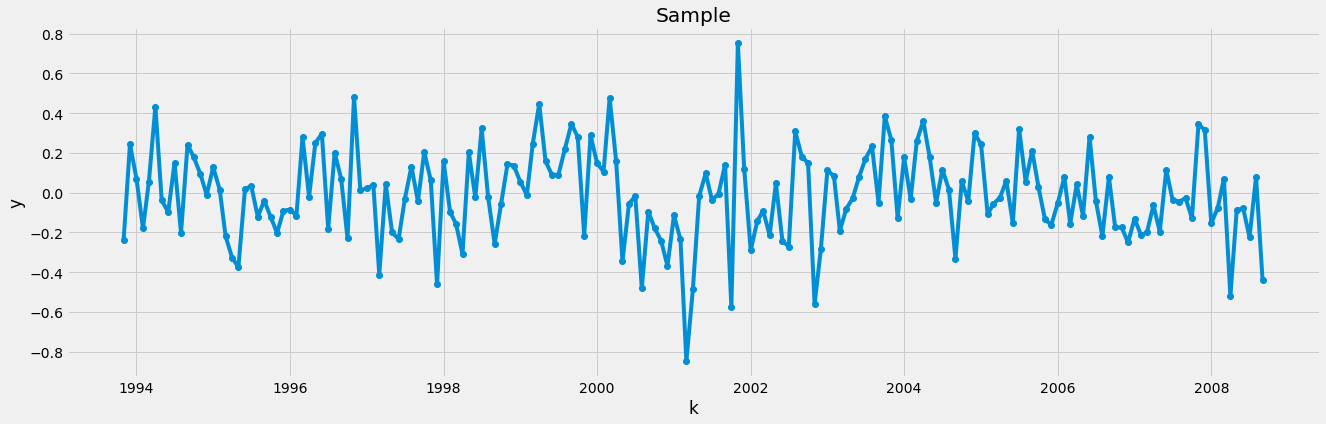

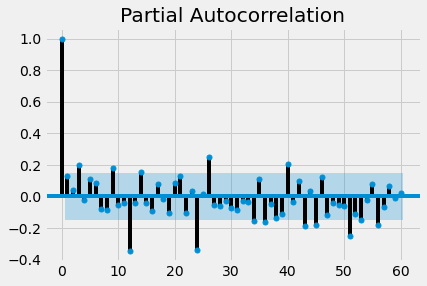

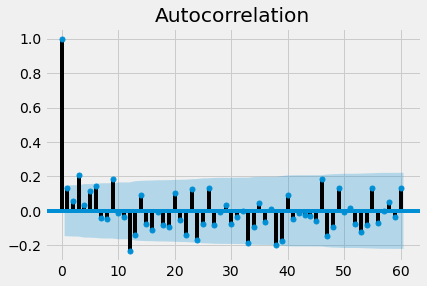

In [51]:
show_plots(res_ma.Residuals)

In [52]:
models_metrics_ma = pd.DataFrame(columns=columns)


best_RMSE=100000000000
best_q = -1

for i in range(1,50):
    
    res_train, res_test,theta,intercept,RMSE = MA(i,pd.DataFrame(res.Residuals))
    metric = claculate_metrics_model(res_test.Residuals, res_test.Predicted_Values, f'MA({i})', i)
    models_metrics_ma = models_metrics_ma.append(metric)
    
    
    if(RMSE<best_RMSE):
        best_RMSE = RMSE
        best_q = i

In [53]:
print(f'best_q:\t {best_q}')

best_q:	 24


In [54]:
models_metrics_ma

,name,r2,RMSE,MAE,sum_squared_resid,AIC,durbin_watson,theil_index
0,MA(1),0.93816052,0.23111654,0.14943080,1.30229403,-117.49809721,2.00179074,0.99877954
0,MA(2),0.93816052,0.23111654,0.14985693,1.30618852,-115.39060041,1.99021746,0.98434487
0,MA(3),0.93816052,0.23111654,0.14540226,1.22993592,-115.55604729,1.94521994,0.82629865
0,MA(4),0.93816052,0.23111654,0.14539851,1.22928979,-113.57496443,1.94488635,0.82594531
0,MA(5),0.93816052,0.23111654,0.14076704,1.18647189,-112.85125411,1.93900173,0.78529015
0,MA(6),0.93816052,0.23111654,0.14626806,1.24212142,-109.20113513,1.89221752,0.79210242
0,MA(7),0.93816052,0.23111654,0.14798615,1.25305081,-106.88575756,1.93741828,0.78909377
0,MA(8),0.93816052,0.23111654,0.14500802,1.23586882,-105.38280979,1.87666882,0.76741439
0,MA(9),0.93816052,0.23111654,0.13780447,1.21109790,-104.11169884,1.76280621,0.75462715
0,MA(10),0.93816052,0.23111654,0.13848299,1.22122622,-101.81188558,1.77961423,0.75871676


In [55]:
best_q_arma=24
res_train_ma, res_test_ma,theta_ma,intercept_ma,RMSE = MA(best_q_arma,pd.DataFrame(res_ma.Residuals))

In [56]:
res_c_ma = pd.concat([res_train_ma,res_test_ma])
df_c_arma = df_c_ar
df_c_arma.Predicted_Values += res_c_ma.Predicted_Values

## detrended come back to real value

In [57]:
df_c_arma.Value *= y.rolling(window=rolling_value).std().Value
df_c_arma.Value += y.rolling(window=rolling_value).mean().Value

df_c_arma.Predicted_Values *= y.rolling(window=rolling_value).std().Value
df_c_arma.Predicted_Values += y.rolling(window=rolling_value).mean().Value

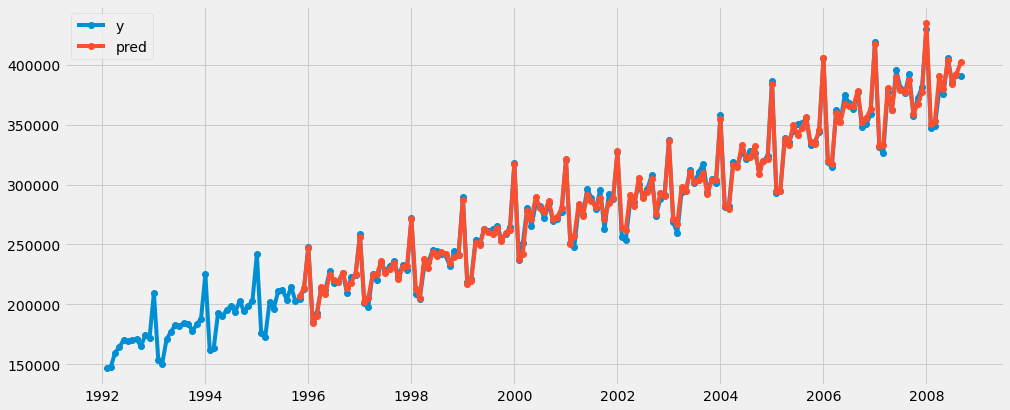

In [58]:
show_prediction(y, df_c_arma.Predicted_Values)

In [59]:
predictions = df_c_arma.Predicted_Values.dropna()[df_test.index]
values = y.Value[df_test.index]
name = f'ARMA_test{best_p_ar,best_q_arma}'
parametrs = best_p_ar+best_q_arma
metrics = claculate_metrics_model(values, predictions, name=name, count_parameters=parametrs)
models_metrics_static_test = models_metrics_static_test.append(metrics)

In [60]:
predictions = df_c_arma.Predicted_Values.dropna()
values = y.Value[df_c_arma.Predicted_Values.dropna().index]
name = f'ARMA{best_p_ar, best_q_arma}'
parametrs = best_p_ar + best_q_arma
metrics = claculate_metrics_model(values, predictions, name=name, count_parameters=parametrs)
models_metrics_static = models_metrics_static.append(metrics)

# ================================================

# Linear regression model 

In [61]:
from sklearn.preprocessing import PolynomialFeatures

def trend_equal(y, trend=1):   
    
    df_temp = y
    
    date_start = np.array(str(df_temp.index[0])[:7], dtype=np.datetime64)
    date_start = date_start + np.arange(len(y))
    y_new = df_temp.values

    X = np.array([x for x in range(1, len(df_temp))])
    X = np.reshape(X, (len(X), 1))
    
    train_size = (int)(precent_train_set * df_temp.shape[0])
    df_train = pd.DataFrame(y[:train_size])
    df_test = pd.DataFrame(y[train_size:])
    
    x_train = pd.DataFrame(X[:train_size])
    y_train = pd.DataFrame(y_new[:train_size])

    x_test = pd.DataFrame(X[train_size - 1:])
    y_test = pd.DataFrame(y_new[train_size:])

    
    if trend != 1:
        pf = PolynomialFeatures(degree=trend)
        x_train = pf.fit_transform(x_train)
        x_test = pf.fit_transform(x_test)

    model = LinearRegression()
    model.fit(x_train, y_train)
    
    pred_train = model.predict(x_train)
    pred_test = model.predict(x_test)
    
    pred_train = np.reshape(pred_train, (len(pred_train), ))
    pred_test = np.reshape(pred_test, (len(pred_test, )))
    
    train_df = pd.DataFrame({'Date': date_start[:train_size], 'Value': pred_train}).set_index('Date')
    test_df = pd.DataFrame({'Date': date_start[train_size :], 'Value': pred_test}).set_index('Date')
    
    df_train['Predicted_Values'] = train_df.Value
    df_test['Predicted_Values'] = test_df.Value  
        
    RMSE = np.sqrt(mean_squared_error(df_test['Value'], df_test['Predicted_Values']))
    
    return df_train, df_test, model.coef_, model.intercept_, RMSE

In [62]:
models_metrics_trend = pd.DataFrame(columns=columns)

best_RMSE = 1e15
best_t = -1

for i in range(1, 6):
#     print(i)
    df_train, df_test, theta, intercept, RMSE = trend_equal(pd.DataFrame(y.Value), i)
    metric = claculate_metrics_model(df_test.Value, df_test.Predicted_Values, f'trend({i})', i)
    models_metrics_trend = models_metrics_trend.append(metric)
    
    print(f'\ntrend:\t {i}')
    print(f'theta:\n {theta}')
    print(f'intercept:\n {intercept}')
    
    if RMSE < best_RMSE:
        best_RMSE = RMSE
        best_t = i
        
print(f'best_trend:\t{best_t}')


trend:	 1
theta:
 [[1050.10998477]]
intercept:
 [160047.03372642]

trend:	 2
theta:
 [[ 0.00000000e+00  1.08080926e+03 -1.90678736e-01]]
intercept:
 [159218.15326308]

trend:	 3
theta:
 [[ 0.00000000e+00  1.14915151e+03 -1.24859466e+00  4.38060426e-03]]
intercept:
 [158286.97566258]

trend:	 4
theta:
 [[ 0.00000000e+00  1.14274511e+03 -1.07083258e+00  2.66668142e-03
   5.32274169e-06]]
intercept:
 [158339.99201218]

trend:	 5
theta:
 [[ 0.00000000e+00  2.57001439e+03 -6.23545945e+01  1.01293234e+00
  -7.04283873e-03  1.75109600e-05]]
intercept:
 [150345.9736136]
best_trend:	4


In [63]:
models_metrics_trend

,name,r2,RMSE,MAE,sum_squared_resid,AIC,durbin_watson,theil_index
0,trend(1),-0.17687544,28304.85192563,22869.02534432,32046585701.27745438,822.06308121,1.40557758,0.03955879
0,trend(2),-0.25765830,29260.17830506,23900.21218576,34246321377.74558258,826.71862147,1.31530643,0.04097995
0,trend(3),-0.11234638,27517.92363755,22081.70049520,30289444852.89115906,823.80742720,1.48709264,0.03838915
0,trend(4),-0.09899950,27352.33361861,21905.57508965,29926006175.35693741,825.32457028,1.50514916,0.03814280
0,trend(5),-11.76135212,93206.02429641,70334.71112764,347494518605.69409180,925.40541096,0.13402737,0.11590399


In [64]:
best_t = 4
df_train_trend, df_test_trend, theta_trend, intercept_trend, RMSE = trend_equal(pd.DataFrame(y.Value), best_t)

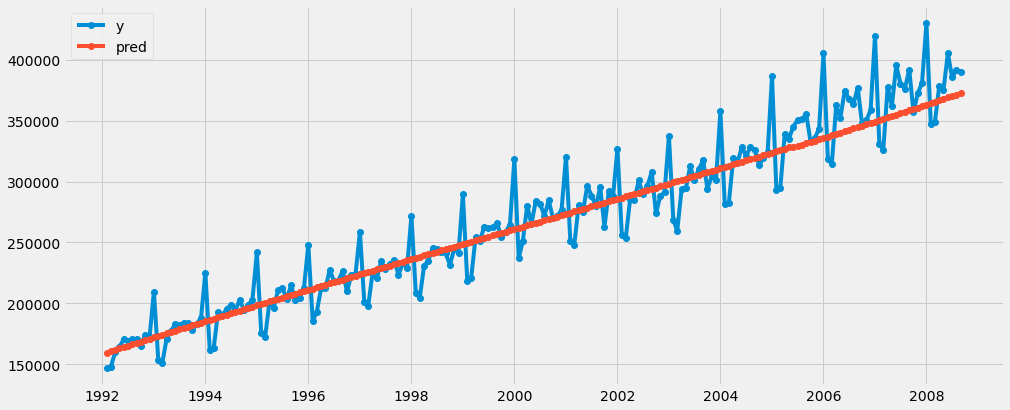

In [65]:
df_c = pd.concat([df_train_trend,df_test_trend])
show_prediction(y, df_c.Predicted_Values)

## Calculate metrix for LR

In [66]:
predictions = df_c.Predicted_Values.dropna()[df_test.index]
values = y.Value[df_test.index]
name = f'LR({best_t})'
parametrs = best_t
metrics = claculate_metrics_model(values, predictions, name=name, count_parameters=parametrs)
models_metrics_static_test = models_metrics_static_test.append(metrics)

In [67]:
predictions = df_c.Predicted_Values.dropna()
values = y.Value[df_c.Predicted_Values.dropna().index]
name = f'LR({best_t})'
parametrs = best_t
metrics = claculate_metrics_model(values, predictions, name=name, count_parameters=parametrs)
models_metrics_static = models_metrics_static.append(metrics)

## Metrics for static_prediction 

In [68]:
models_metrics_static_test

,name,r2,RMSE,MAE,sum_squared_resid,AIC,durbin_watson,theil_index
0,"ARIMA_test(12, 1, 24)",0.97044889,0.23840761,3340.34902443,755673114.54307294,744.16959993,1.38925932,0.00591798
0,AR_test12,0.93816052,0.23111654,365831.51844680,5380536661747.52734375,1048.99719129,0.00838068,0.99999629
0,"ARMA_test(12, 24)",0.93816052,0.23111654,3511.11060474,810902863.28742027,744.99117507,1.32704825,0.00613131
0,LR(4),-11.76135212,93206.02429641,21905.57508965,29926006175.35693741,825.32457028,1.50514916,0.03814280


In [69]:
models_metrics_static

,name,r2,RMSE,MAE,sum_squared_resid,AIC,durbin_watson,theil_index
0,"ARIMA(12, 1, 24)",0.97044889,0.23840761,3006.36243053,2305443096.01909161,2618.32426326,1.82055147,0.00646285
0,AR(12),0.93816052,0.23111654,3505.59460894,3674873644.18382502,3037.89438174,1.70901031,0.00788354
0,"ARMA(12, 24)",0.93816052,0.23111654,3032.27301135,2315747852.20671272,2632.53387726,1.75043645,0.00646770
0,LR(4),-11.76135212,93206.02429641,14234.57965645,82206134816.67657471,3974.83568050,1.93577758,0.03687055


## Plots for static prediction

In [70]:
def plot_all_grafics(df_y, df_ar, df_arma, df_arima, df_lr, period, name='All models prediction'):
    plt.figure(figsize= (15,6.5))
    plt.title(name)
    
    plt.plot(df_y.Value[period], label='y', marker='o')
    plt.plot(df_ar.Predicted_Values[period], label='pred_AR', marker='o')
    plt.plot(df_arma.Predicted_Values[period], label='pred_ARMA', marker='o')
    plt.plot(df_arima.Predicted_Values[period], label='pred_ARIMA', marker='o')
    plt.plot(df_lr.Predicted_Values[period], label='pred_LR', marker='o')
    plt.legend()
    plt.show()

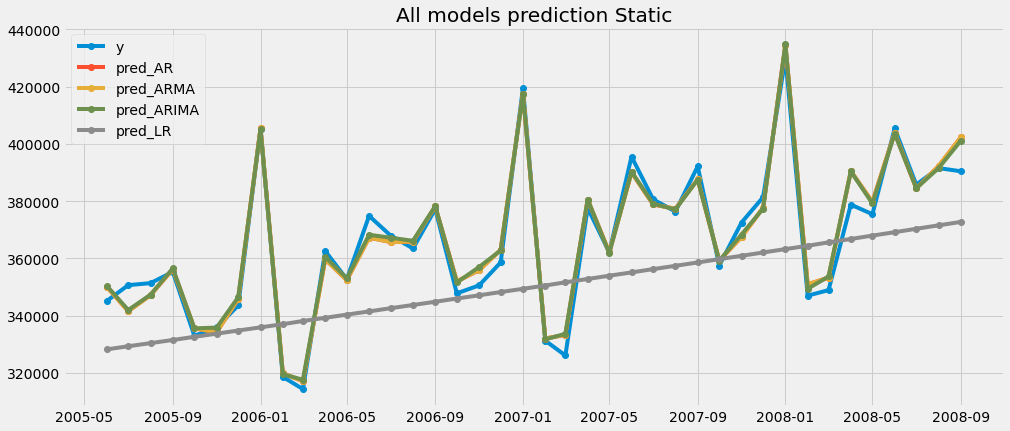

In [71]:
df_y = y
df_ar = df_c_ar
df_arma = df_c_arma
df_arima = df_c_arima
df_lr = df_test_trend
period = df_test_trend.Predicted_Values.index
name='All models prediction Static'
plot_all_grafics(df_y, df_ar, df_arma, df_arima, df_lr, period, name)

# Dinamic prediction

In [72]:
def dinamic_prediction_arma(p,q, df_y, df_res, coef_ar, coef_ma, intercept_ar, intercept_ma, period_predict):
    
    print(f'p:\t{p}\nq:\t{q}')
    print(f'len_coef_ar:\t{len(coef_ar)}')
    print(f'len_coef_ma:\t{len(coef_ma)}')
    print(f'preriod:\t{period_predict.shape[0]}')
    
    df_temp_y = df_y
    df_temp_res = df_res
   
    y_predict = np.array(df_temp_y.Value[-p:])
    res_predict = np.array(df_temp_res.Residuals[-q:])
    
    y_result = np.array([])
    
    coef_ar = coef_ar[::-1]
    coef_ma = coef_ma[::-1]
    
    for i in range(period_predict.shape[0]):
        
        y_temp = np.dot(y_predict, coef_ar) + intercept_ar
        res_temp = np.dot(res_predict, coef_ma) + intercept_ma
        y_temp += res_temp 
        y_result = np.append(y_result, y_temp)
        
        y_predict = np.delete(y_predict, 0)
        res_predict = np.delete(res_predict, 0)

        y_predict = np.append(y_predict, y_temp)
        res_predict = np.append(res_predict, res_temp)

    
    return pd.DataFrame({'Date': period_predict, 'Predicted_Values':y_result}).set_index('Date')

### Dinamic ARIMA

In [73]:
models_metrics_dinamic_test_before = pd.DataFrame(columns=columns)
models_metrics_dinamic_test_after = pd.DataFrame(columns=columns)

In [74]:
# arima prediction
p = best_p_arima
q = best_q_arima
df_y = df_train_lag
df_res = res_train_lag

coef_ar = theta_ar_lag
coef_ma = theta_ma_lag
intercept_ar = intercept_ar_lag 
intercept_ma =  intercept_ma_lag
period_predict = df_test_trend.Predicted_Values.index

y_dinamic_arima = dinamic_prediction_arma(p=p,q=q, df_y=df_y, df_res=df_res, coef_ar=coef_ar, coef_ma=coef_ma, 
                        intercept_ar=intercept_ar, intercept_ma=intercept_ma, period_predict=period_predict)

p:	12
q:	24
len_coef_ar:	12
len_coef_ma:	24
preriod:	40


In [75]:
predictions = y_dinamic_arima.Predicted_Values
values = y_10lag_detrend.Value[df_test_trend.Predicted_Values.index]
name = f'ARIMA_din_after({p,diff_model,q})'
parametrs = p + q +diff_model
metrics = claculate_metrics_model(values, predictions, name=name, count_parameters=parametrs)
models_metrics_dinamic_test_before = models_metrics_dinamic_test_before.append(metrics)

In [76]:
#come back
y_dinamic_arima.Predicted_Values += y_detrend.shift(diff_model).Value[df_test_trend.Predicted_Values.index]
y_dinamic_arima.Predicted_Values *= y.rolling(window=rolling_value).std().Value[df_test_trend.Predicted_Values.index]
y_dinamic_arima.Predicted_Values += y.rolling(window=rolling_value).mean().Value[df_test_trend.Predicted_Values.index]

In [77]:
predictions = y_dinamic_arima.Predicted_Values
values = y.Value[df_test_trend.Predicted_Values.index]
name = f'ARIMA_dinam({p,diff_model,q})'
parametrs = p + q +diff_model
metrics = claculate_metrics_model(values, predictions, name=name, count_parameters=parametrs)
models_metrics_dinamic_test_after = models_metrics_dinamic_test_after.append(metrics)

#### Dinamic ARMA

In [78]:
# arima prediction
p = best_p_ar
q = best_q_arma
df_y = df_train_ar
df_res = res_train_ma

coef_ar = theta_ar
coef_ma = theta_ma
intercept_ar = intercept_ar 
intercept_ma =  intercept_ma
period_predict = df_test_trend.Predicted_Values.index

y_dinamic_arma = dinamic_prediction_arma(p=p,q=q, df_y=df_y, df_res=df_res, coef_ar=coef_ar, coef_ma=coef_ma, 
                        intercept_ar=intercept_ar, intercept_ma=intercept_ma, period_predict=period_predict)

p:	12
q:	24
len_coef_ar:	12
len_coef_ma:	24
preriod:	40


In [79]:
predictions = y_dinamic_arma.Predicted_Values
values = y_detrend.Value[df_test_trend.Predicted_Values.index]
name = f'ARMA_din_after({p,q})'
parametrs = p + q
metrics = claculate_metrics_model(values, predictions, name=name, count_parameters=parametrs)
models_metrics_dinamic_test_before = models_metrics_dinamic_test_before.append(metrics)

In [80]:
# come back arma 
y_dinamic_arma.Predicted_Values *= y.rolling(window=rolling_value).std().Value[df_test_trend.Predicted_Values.index]
y_dinamic_arma.Predicted_Values += y.rolling(window=rolling_value).mean().Value[df_test_trend.Predicted_Values.index]

In [81]:
predictions = y_dinamic_arma.Predicted_Values
values = y.Value[df_test_trend.Predicted_Values.index]
name = f'ARMA_din({p,q})'
parametrs = p + q
metrics = claculate_metrics_model(values, predictions, name=name, count_parameters=parametrs)
models_metrics_dinamic_test_after = models_metrics_dinamic_test_after.append(metrics)

### Dinamic AR

In [82]:
def dinamic_prediction_ar(p, df_y, coef_ar, intercept_ar, period_predict):
    
    print(f'p:\t{p}')
    
    df_temp_y = df_y
    y_predict = np.array(df_temp_y.Value[-p:])
    y_result = np.array([])
    coef_ar = coef_ar[::-1]
    
    for i in range(period_predict.shape[0]):
        
        y_temp = np.dot(y_predict, coef_ar) + intercept_ar
        y_result = np.append(y_result, y_temp)
        
        y_predict = np.delete(y_predict, 0)

        y_predict = np.append(y_predict, y_temp)

    
    return pd.DataFrame({'Date': period_predict, 'Predicted_Values':y_result}).set_index('Date')

In [83]:
# ar prediction
p = best_p_ar
df_y = df_train_ar

coef_ar = theta_ar
intercept_ar = intercept_ar 
period_predict = df_test_trend.Predicted_Values.index

y_dinamic_ar = dinamic_prediction_ar(p=p,df_y=df_y, coef_ar=coef_ar, intercept_ar=intercept_ar, 
                                         period_predict=period_predict)

p:	12


In [84]:
predictions = y_dinamic_ar.Predicted_Values
values = y_detrend.Value[df_test_trend.Predicted_Values.index]
name = f'AR_din_after({p})'
parametrs = p 
metrics = claculate_metrics_model(values, predictions, name=name, count_parameters=parametrs)
models_metrics_dinamic_test_before = models_metrics_dinamic_test_before.append(metrics)

In [85]:
# come back ar 
y_dinamic_ar.Predicted_Values *= y.rolling(window=rolling_value).std().Value[df_test_trend.Predicted_Values.index]
y_dinamic_ar.Predicted_Values += y.rolling(window=rolling_value).mean().Value[df_test_trend.Predicted_Values.index]

In [86]:
predictions = y_dinamic_ar.Predicted_Values
values = y.Value[df_test_trend.Predicted_Values.index]
name = f'AR_din({p})'
parametrs = p 
metrics = claculate_metrics_model(values, predictions, name=name, count_parameters=parametrs)
models_metrics_dinamic_test_after = models_metrics_dinamic_test_after.append(metrics)

## comparing all metrics

###  Dinamic metrics on test set after come back to real values

In [87]:
models_metrics_dinamic_test_after

,name,r2,RMSE,MAE,sum_squared_resid,AIC,durbin_watson,theil_index
0,"ARIMA_dinam((12, 1, 24))",-11.76135212,93206.02429641,7866.08667454,4050055155.86591721,811.32467530,3.20677849,0.01371804
0,"ARMA_din((12, 24))",-11.76135212,93206.02429641,5911.59443539,2468103144.67670727,789.51345123,1.78750150,0.01076198
0,AR_din(12),-11.76135212,93206.02429641,4885.89931491,1775369533.64097643,728.33579888,1.52368037,0.00912263


###  Static metrics on test set after come back to real value

In [88]:
models_metrics_static_test

,name,r2,RMSE,MAE,sum_squared_resid,AIC,durbin_watson,theil_index
0,"ARIMA_test(12, 1, 24)",0.97044889,0.23840761,3340.34902443,755673114.54307294,744.16959993,1.38925932,0.00591798
0,AR_test12,0.93816052,0.23111654,365831.51844680,5380536661747.52734375,1048.99719129,0.00838068,0.99999629
0,"ARMA_test(12, 24)",0.93816052,0.23111654,3511.11060474,810902863.28742027,744.99117507,1.32704825,0.00613131
0,LR(4),-11.76135212,93206.02429641,21905.57508965,29926006175.35693741,825.32457028,1.50514916,0.03814280


## plot for Dinamic predictions

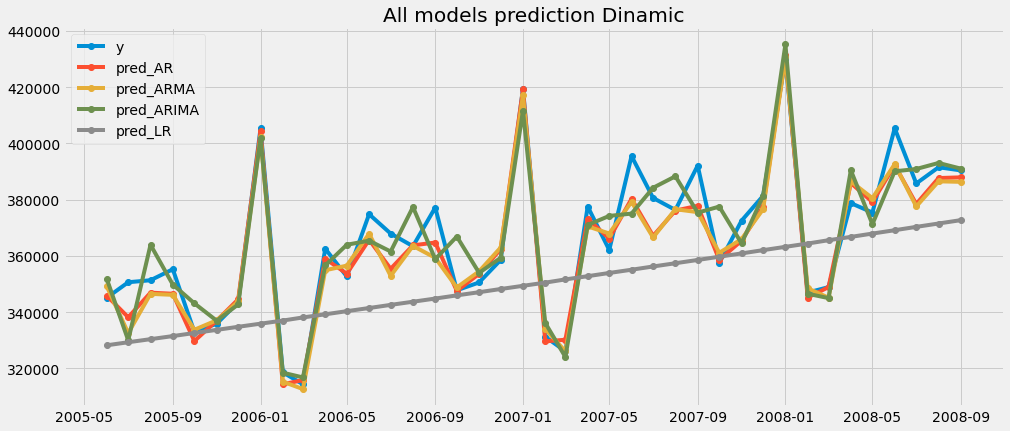

In [89]:
df_y = y
df_ar = y_dinamic_ar
df_arma = y_dinamic_arma
df_arima = y_dinamic_arima
df_lr = df_test_trend
period = df_test_trend.Predicted_Values.index
name='All models prediction Dinamic'
plot_all_grafics(df_y, df_ar, df_arma, df_arima, df_lr, period, name)